## C1조_종합실습2(후판 공정 불량 영향 인자 분석 프로젝트)

In [47]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [48]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')


In [49]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt

matplotlib.rc("font", family = "NanumBarunGothic")
matplotlib.rc('axes', unicode_minus=False)

In [66]:
import warnings
import platform
warnings.filterwarnings('ignore')

## 1. 모델 불러오기

In [92]:
df_raw = pd.read_csv("/content/drive/MyDrive/python_posco/SCALE불량.csv", encoding = 'euc-kr')
df_raw.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조


## 2. 통계 분석

In [93]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   object
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   object
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  rolling_method   1000 non-null   o

In [94]:
df_raw.describe()

,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,26.78200,2831.900000,36788.200000,1157.245000,85.972000,1150.928000,71.720000,238.589000,934.637000,8.557000
std,18.13757,494.081478,13912.387116,21.245007,26.346297,17.344384,20.602137,38.194828,96.598015,1.604158
min,12.00000,1800.000000,7900.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,0.000000,5.000000
25%,15.00000,2500.000000,26650.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,893.750000,8.000000
50%,19.00000,2800.000000,40400.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,948.000000,9.000000
75%,34.00000,3100.000000,49100.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,991.000000,10.000000
max,100.00000,4600.000000,54900.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1078.000000,10.000000


plate_no 는 분석에 필요하지 Plate 번호 정보 → 열 삭제

In [95]:
df = df_raw
df.drop(labels = 'plate_no', axis = 1, inplace = True)

##### spec_long의 경우 제품 규격을 나타냄 '-'로 구분뒤어 ’규격’+’강제 등급’+’열처리 방식’의 정보를 포함하고 있음

## 3. 결측치 제거

In [96]:
df.isnull().sum()

,0
rolling_date,0
scale,0
spec_long,0
spec_country,0
steel_kind,0
pt_thick,0
pt_width,0
pt_length,0
hsb,0
fur_no,0


##### 데이터의 결측치를 확인해본 결과 결측치가 존재하지 않음

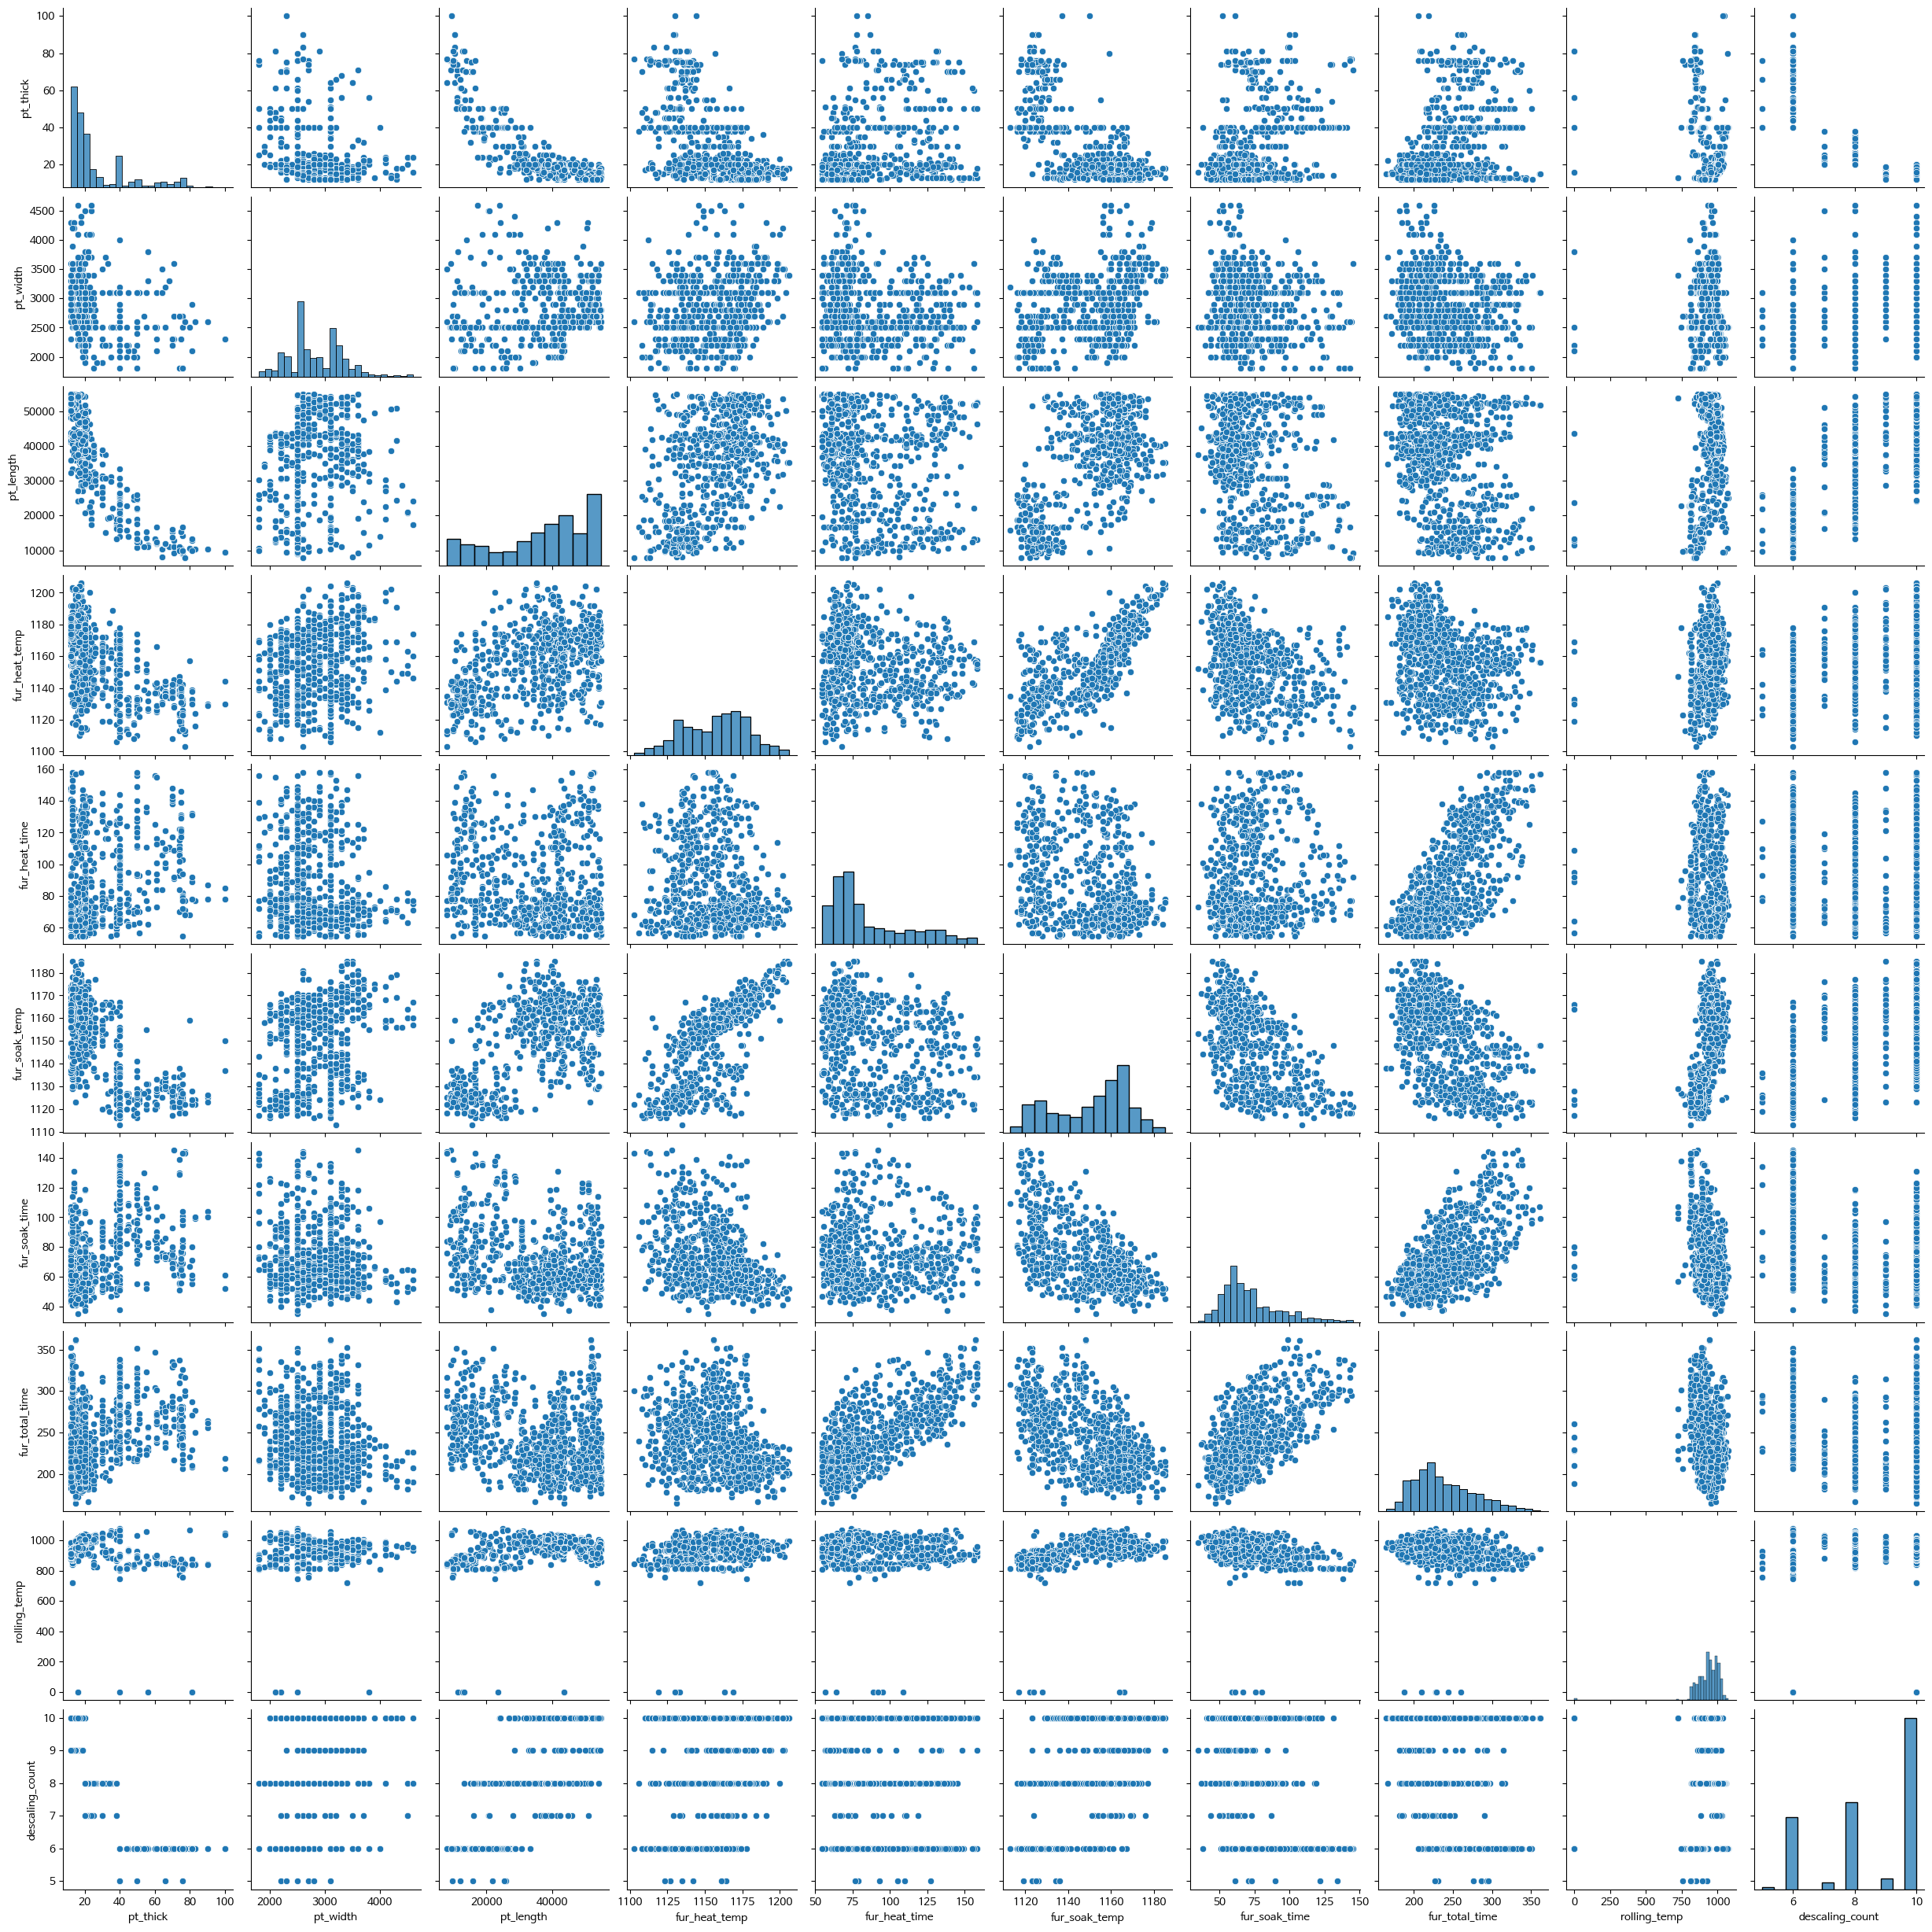

In [97]:
sns.pairplot(df)

그래프 확인 결과, rolling_temp가 0인 이상치를 확인할 수 있다

In [74]:
outliers = df[df['rolling_temp'] == 0]
outliers

,rolling_date,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
53,03JAN2023:16:22:29,GL-E36-TM,독일,T,56,3800,11400,적용,3호기,2열,1132,95,1128,80,244,TMCP(온도제어),0,6,1조
221,04JAN2023:19:44:09,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,2열,1163,57,1166,67,228,CR(제어압연),0,10,2조
222,04JAN2023:19:56:39,JS-SM490YB,일본,C,16,2200,43600,적용,3호기,1열,1169,64,1164,61,188,CR(제어압연),0,10,2조
598,07JAN2023:11:40:51,PILAC-BT33,한국,T,81,2100,12900,적용,2호기,1열,1133,89,1122,59,229,CR(제어압연),0,6,3조
599,07JAN2023:11:52:00,PILAC-BT33,한국,T,81,2100,13200,적용,1호기,2열,1130,92,1124,61,210,CR(제어압연),0,6,3조
600,07JAN2023:11:59:10,NV-D32-TM,영국,T,40,2500,23600,적용,3호기,1열,1119,109,1117,76,260,TMCP(온도제어),0,6,3조


그래프 확인 결과, rolling_temp가 0인 이상치는 총 6개


rolling_temp 가 0인 이상치 중, [Spec_long  , spec_country, steel_kind, rolling_method]가 동일하여 완전 동일 제품으로 판단된다면 값 대체한다

In [98]:
matched_normal_data = normal_data.merge(
    matched_outliers,
    on=["spec_long", "spec_country", "steel_kind", "rolling_method"],
    suffixes=('_normal', '_outlier')
)
selected_columns = matched_normal_data[["spec_long", "spec_country", "steel_kind", "rolling_method", "rolling_temp_normal"]]

# 출력
selected_columns

,spec_long,spec_country,steel_kind,rolling_method,rolling_temp_normal
0,GL-E36-TM,독일,T,TMCP(온도제어),836
1,GL-E36-TM,독일,T,TMCP(온도제어),832
2,GL-E36-TM,독일,T,TMCP(온도제어),832
3,GL-E36-TM,독일,T,TMCP(온도제어),832
4,GL-E36-TM,독일,T,TMCP(온도제어),841
...,...,...,...,...,...
253,PILAC-BT33,한국,T,CR(제어압연),876
254,PILAC-BT33,한국,T,CR(제어압연),842
255,PILAC-BT33,한국,T,CR(제어압연),842
256,JS-SM490YB,일본,C,CR(제어압연),973


rolling_temp 가 0인 이상치 중 동일 제품이 존재함을 확인할 수 있다

In [99]:
group_cols = ['spec_long', 'spec_country', 'steel_kind', 'rolling_method']
df['rolling_temp'] = df.groupby(group_cols)['rolling_temp'].transform(
    lambda x: x.replace(0, x[x != 0].mean() if not x[x != 0].empty else 0)
)

In [100]:
outliers = df[df['rolling_temp'] == 0]
outliers

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group


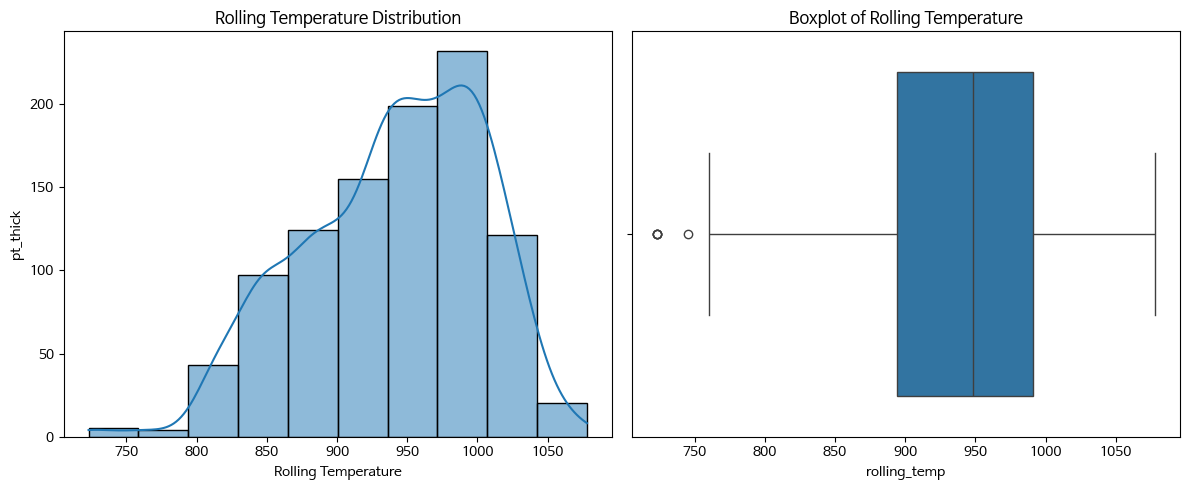

In [101]:
# 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 히스토그램
sns.histplot(df["rolling_temp"], bins=10, kde=True, ax=axes[0])
axes[0].set_title("Rolling Temperature Distribution")
axes[0].set_xlabel("Rolling Temperature")
axes[0].set_ylabel("pt_thick")

# 박스플롯
sns.boxplot(x=df["rolling_temp"], ax=axes[1])
axes[1].set_title("Boxplot of Rolling Temperature")

plt.tight_layout()
plt.show()

In [102]:
df_sorted = df.sort_values(by="rolling_temp", ascending=True)
print(df_sorted)


           rolling_date scale  spec_long spec_country steel_kind  pt_thick  \
632  07JAN2023:17:10:22    양품       LR-A           영국          C        13   
633  07JAN2023:17:16:29    양품      NK-KA           일본          C        13   
634  07JAN2023:17:24:17    양품       NV-A           영국          C        13   
631  07JAN2023:17:02:18    양품       BV-A          프랑스          C        13   
549  07JAN2023:03:06:44    양품  GL-A36-TM           독일          T        40   
..                  ...   ...        ...          ...        ...       ...   
188  04JAN2023:14:34:33    불량   JS-SS400           일본          C        40   
191  04JAN2023:15:01:42    불량   JS-SS400           일본          C        80   
716  08JAN2023:07:04:51    불량  KS-SM400A           한국          C        40   
715  08JAN2023:06:57:53    불량   JS-SS400           일본          C        40   
187  04JAN2023:14:28:38    불량   JS-SS400           일본          C        40   

     pt_width  pt_length hsb fur_no fur_input_row  fur_heat_tem

rolling_temp 가 0인 이상치가 전부 사라짐을 확인할 수 있다

## 4. 파생변수

파생변수


1.   강철 용도에 따른 그룹 (일반구조용,선체 구조용,교량구조용,용접구조용, 해양구조용, 보일러압력)
2.   노냉시간  (fur_total_time - fur_soak_time - fur_heat_time)
3.   철제 부피 (pt_thick * pt_width *pt_length)
4.   4조2교대(07시,19시 기준) 시간 범위 교대 조
5.   차분 (다시 처리 하기 까지 여유 시간) (동일호기 동일 열의 현재 공정 시간 - 이전 공정 시간)
6.   두께 대비 descaling 횟수
7.   항복 강도





In [103]:
# 3. 철제 부피
df['steel_volume'] = df['pt_thick'] * df['pt_width'] * df['pt_length']

In [125]:
#상관관계 분석을 위해 scale 을 수치형 변환
df['scale_numeric'] = df['scale'].map({'양품': 1, '불량': 0})

In [129]:
correlation = df[['steel_volume', 'scale_numeric']].corr().iloc[0, 1]
print(f"scale과 steel_volume의 상관계수: {correlation:.4f}")

scale과 steel_volume의 상관계수: -0.0157


steel_volume과 scale은 상관 관계가 아니라고 할 수 있다.

In [104]:
# 5. 차분 계산 (fur_no, fur_input_row 기준으로 정렬 후 rolling_date 차이 계산)

#rolling date를 계산하기 위해 일단 데이터 형변환 (예: 04JAN2023:19:02:39 → 2023-01-04 19:02:39)
df['rolling_date'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S')

df.sort_values(by=['fur_no', 'fur_input_row', 'rolling_date'], inplace=True)
df['process_time_diff'] = df.groupby(['fur_no', 'fur_input_row'])['rolling_date'].diff().dt.total_seconds()

In [105]:
df

,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,...,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,steel_volume,process_time_diff
0,2023-01-03 07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,1호기,...,116,1133,59,259,TMCP(온도제어),934.0,8,1조,1787840000,NaN
6,2023-01-03 08:14:02,양품,BV-EH36-TM,프랑스,T,38,3100,16700,적용,1호기,...,126,1130,50,278,TMCP(온도제어),878.0,8,1조,1967260000,3969.0
13,2023-01-03 09:27:31,양품,AB/EH36-TM,미국,T,38,3100,16200,적용,1호기,...,125,1127,62,280,TMCP(온도제어),820.0,8,1조,1908360000,4409.0
14,2023-01-03 09:33:17,양품,COMMON,공통,T,38,3100,16200,적용,1호기,...,125,1127,62,286,CR(제어압연),820.0,8,1조,1908360000,346.0
23,2023-01-03 11:15:19,양품,GL-E32-TM,독일,T,50,2200,21800,적용,1호기,...,122,1125,78,302,TMCP(온도제어),925.0,6,1조,2398000000,6122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,2023-01-10 01:13:26,양품,LR-AH32,영국,C,13,2900,51500,적용,3호기,...,65,1168,58,180,CR(제어압연),908.0,10,4조,1941550000,449.0
969,2023-01-10 01:23:07,양품,NV-A32,영국,C,13,2900,51500,적용,3호기,...,65,1168,58,185,CR(제어압연),908.0,10,4조,1941550000,581.0
984,2023-01-10 03:33:20,양품,AB/A,미국,C,17,3500,32300,적용,3호기,...,65,1160,72,231,CR(제어압연),938.0,10,4조,1921850000,7813.0
985,2023-01-10 03:39:07,양품,LR-A,영국,C,17,3500,32300,적용,3호기,...,65,1160,72,215,CR(제어압연),938.0,10,4조,1921850000,347.0


파생변수 process_time_diff와 scale 간의 상관관계 확인

In [114]:
df_filtered = df.dropna(subset=['process_time_diff'])

In [118]:
df_filtered['scale_numeric'] = df_filtered['scale'].map({'양품': 1, '불량': 0})

In [121]:
correlation = df_filtered[['scale_numeric', 'process_time_diff']].corr().iloc[0, 1]
print(f"Scale과 Process Time Diff의 상관계수: {correlation:.3f}")

Scale과 Process Time Diff의 상관계수: 0.006


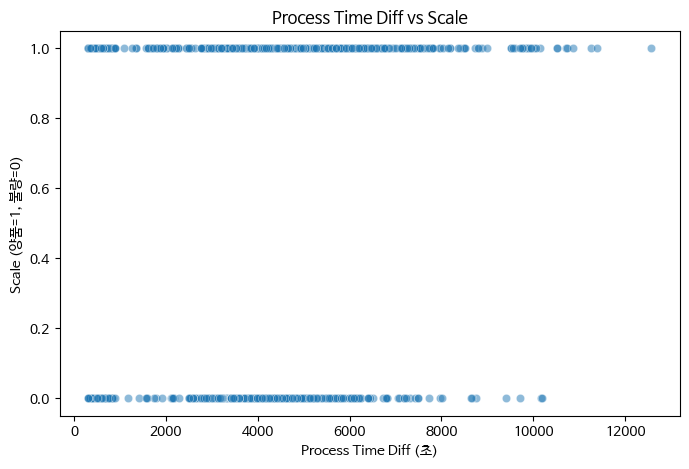

In [123]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='process_time_diff', y='scale_numeric', data=df_filtered, alpha=0.5)
plt.title("Process Time Diff vs Scale")
plt.xlabel("Process Time Diff (초)")
plt.ylabel("Scale (양품=1, 불량=0)")
plt.show()

process_time_diff와 scale은 상관 관계가 아니라고 할 수 있다.

In [131]:
#6. 두께 대비 descaling 횟수
df["descaling_per_thickness"] = df["descaling_count"] / df["pt_thick"]

In [132]:
correlation = df[['descaling_per_thickness', 'scale_numeric']].corr().iloc[0, 1]
print(f"descaling_per_thickness과 scale 간의 상관계수: {correlation:.4f}")

descaling_per_thickness과 scale 간의 상관계수: 0.0845



descaling_per_thickness와 scale은 상관 관계가 아니라고 할 수 있다.

In [136]:
# 표면적
df["surface_area"] = 2 * (df["pt_thick"] * df["pt_width"] +
                          df["pt_thick"] * df["pt_length"] +
                          df["pt_width"] * df["pt_length"]) / 1000000

In [137]:
correlation = df[['surface_area', 'scale_numeric']].corr().iloc[0, 1]
print(f"surface_area과 scale 간의 상관계수: {correlation:.4f}")

surface_area과 scale 간의 상관계수: 0.0453



surface_area와 scale은 상관 관계가 아니라고 할 수 있다.

In [140]:
# 가열 효율성
df["heating_efficiency"] = df["fur_heat_temp"] / df["fur_heat_time"]
# 침지 효율성 단위 시간당 유지 온도 효율
df["soaking_efficiency"] = df["fur_soak_temp"] / df["fur_soak_time"]

In [141]:
correlation = df[['heating_efficiency', 'scale_numeric']].corr().iloc[0, 1]
print(f"heating_efficiency scale 간의 상관계수: {correlation:.4f}")

heating_efficiency scale 간의 상관계수: -0.0279


In [142]:
correlation = df[['soaking_efficiency', 'scale_numeric']].corr().iloc[0, 1]
print(f"soaking_efficiency scale 간의 상관계수: {correlation:.4f}")

soaking_efficiency scale 간의 상관계수: -0.2303


가열 침지 효율성 모두 상관 관계 없다.

In [144]:
# 온도 변화 관련
df["heat_soak_temp_diff"] = df["fur_heat_temp"] - df["fur_soak_temp"]
df["soak_rolling_temp_diff"] = df["fur_soak_temp"] - df["rolling_temp"]
df["total_temp_drop_rate"] = (df["fur_heat_temp"] - df["rolling_temp"]) / df["fur_heat_temp"] * 100

In [145]:
correlation = df[['heat_soak_temp_diff', 'scale_numeric']].corr().iloc[0, 1]
print(f"heat_soak_temp_diff scale 간의 상관계수: {correlation:.4f}")

heat_soak_temp_diff scale 간의 상관계수: 0.0731


In [146]:
correlation = df[['soak_rolling_temp_diff', 'scale_numeric']].corr().iloc[0, 1]
print(f"soak_rolling_temp_diff scale 간의 상관계수: {correlation:.4f}")

soak_rolling_temp_diff scale 간의 상관계수: 0.4936


In [147]:
correlation = df[['total_temp_drop_rate', 'scale_numeric']].corr().iloc[0, 1]
print(f"total_temp_drop_rate scale 간의 상관계수: {correlation:.4f}")

total_temp_drop_rate scale 간의 상관계수: 0.4782


온도변화 모두 상관 관계 없다.

In [148]:
#시간 효율성
df["heat_time_ratio"] = (df["fur_heat_time"] / df["fur_total_time"]) * 100
df["soak_time_ratio"] = (df["fur_soak_time"] / df["fur_total_time"]) * 100
df["unused_process_time"] = df["fur_total_time"] - (df["fur_heat_time"] + df["fur_soak_time"])

In [149]:
correlation = df[['heat_time_ratio', 'scale_numeric']].corr().iloc[0, 1]
print(f"heat_time_ratio scale 간의 상관계수: {correlation:.4f}")

heat_time_ratio scale 간의 상관계수: -0.0528


In [150]:
correlation = df[['soak_time_ratio', 'scale_numeric']].corr().iloc[0, 1]
print(f"soak_time_ratio scale 간의 상관계수: {correlation:.4f}")

soak_time_ratio scale 간의 상관계수: 0.1954


In [151]:
correlation = df[['unused_process_time', 'scale_numeric']].corr().iloc[0, 1]
print(f"unused_process_time scale 간의 상관계수: {correlation:.4f}")

unused_process_time scale 간의 상관계수: -0.0394


In [158]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 994
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   rolling_date             1000 non-null   datetime64[ns]
 1   scale                    1000 non-null   object        
 2   spec_long                1000 non-null   object        
 3   spec_country             1000 non-null   object        
 4   steel_kind               1000 non-null   object        
 5   pt_thick                 1000 non-null   int64         
 6   pt_width                 1000 non-null   int64         
 7   pt_length                1000 non-null   int64         
 8   hsb                      1000 non-null   object        
 9   fur_no                   1000 non-null   object        
 10  fur_input_row            1000 non-null   object        
 11  fur_heat_temp            1000 non-null   int64         
 12  fur_heat_time            1000 non-null  

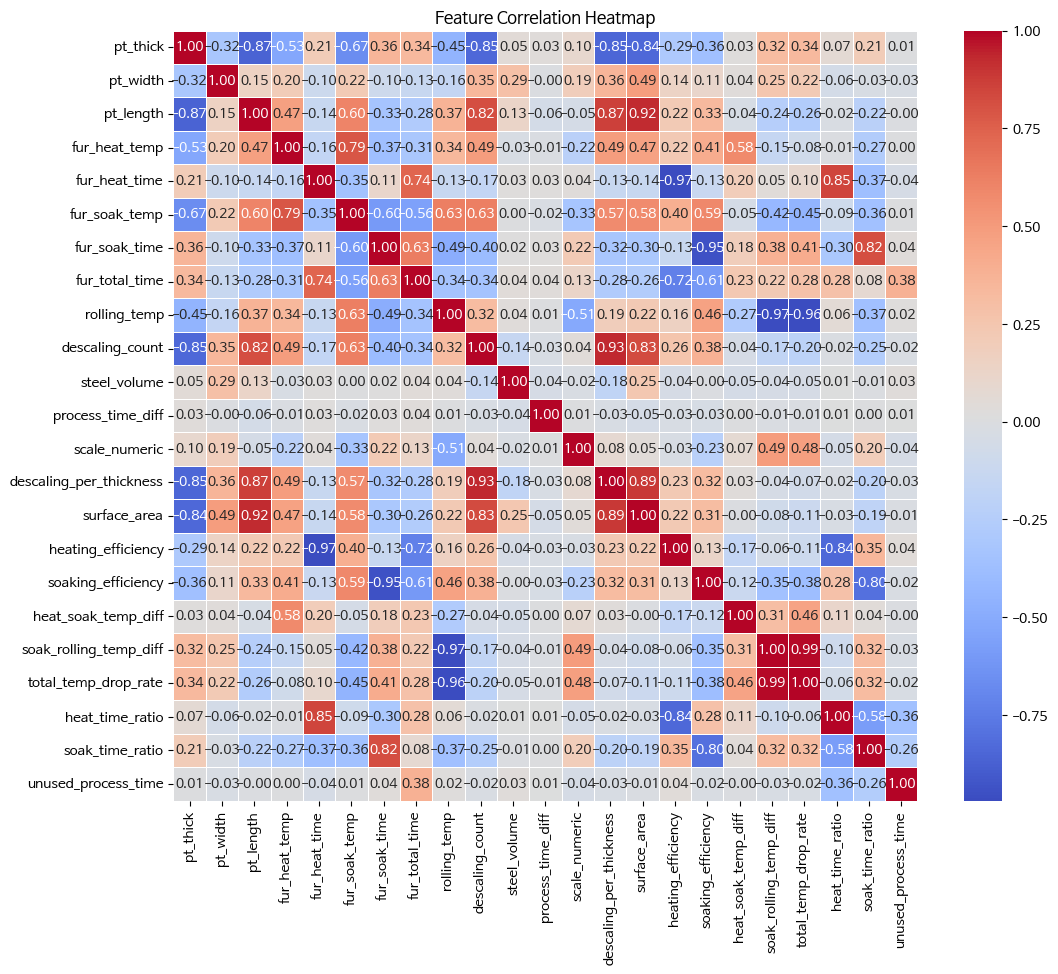

In [160]:
# 수치형 변수만 선택
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

# 상관계수 계산
corr_matrix = df[numeric_cols].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()